# **1: Install Dependencies & Mount Google Drive**

In [ ]:
!pip install transformers==4.30.2
!pip install transformers torch wordcloud seaborn
!pip install wordcloud
!pip install keras-adamw

from google.colab import drive
# Corrected mountpoint: Mount to a directory without spaces
drive.mount('/content/drive')

print("Setup complete! Dependencies installed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.9/314.9 kB 25.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 82.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete! Dependencies installed.


# **2: Import Libraries & Check GPU**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# setup plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("\n⚠️ WARNING: GPU NOT DETECTED!")
    print("⚠️ Training akan SANGAT LAMBAT di CPU!")
    print("\nCara mengaktifkan GPU:")
    print("1. Klik 'Runtime' di menu atas")
    print("2. Pilih 'Change runtime type'")
    print("3. Pilih 'T4 GPU' di dropdown Hardware accelerator")
    print("4. Klik 'Save'")
    print("5. Re-run cell ini setelah runtime restart\n")



PyTorch: 2.8.0+cu126
CUDA Available: True
GPU: Tesla T4
GPU Memory: 14.74 GB


# **3: Load Dataset**

In [ ]:

file_path = '/content/drive/MyDrive/Project Data Analytics/Sentimen Analysis/Data/scrapped_data_105077_honor of kings.csv'

df = pd.read_csv(file_path)

print(f"Dataset loaded: {len(df)} rows")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nData info:\n{df.info()}")


Dataset loaded: 105077 rows

Columns: ['userName', 'score', 'at', 'content']

First few rows:
          userName  score                   at  \
0  Pengguna Google      5  2024-07-25 11:23:52   
1  Pengguna Google      5  2024-07-27 02:05:45   
2  Pengguna Google      5  2024-07-25 06:26:59   
3  Pengguna Google      2  2024-07-27 20:07:32   
4  Pengguna Google      4  2024-07-25 01:32:17   

                                             content  
0  Secara keseluruhan nih game bagus sih, gamepla...  
1  ada kekurangan dari kontrolnya yg mana percepa...  
2  Game nya susah bagus tapi . Jeleknya pass mau ...  
3  Dark system nya lebih parah dr sebelah awokawo...  
4  untuk event event nya sangat menyenangkan dan ...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105077 entries, 0 to 105076
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   userName  105077 non-null  object
 1   score     105077 non-null  int64 
 2   at  

# **4: Data Cleaning**

In [ ]:
# remove missing values
df_clean = df.dropna().copy()
df_clean = df_clean[df_clean['content'].str.len() > 10]

def clean_text(text):
    # basic preprocessing
    stop_words = {'yang', 'adalah', 'dan', 'untuk', 'di', 'sebuah', 'dari',
                  'pada', 'dengan', 'ini', 'bahwa', 'itu', 'ke', 'akan'}

    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text.strip()

df_clean['content_cleaned'] = df_clean['content'].apply(clean_text)

# convert score to sentiment
def score_to_sentiment(score):
    if score > 3:
        return 'positive'
    elif score < 3:
        return 'negative'
    else:
        return 'neutral'

df_clean['sentiment'] = df_clean['score'].apply(score_to_sentiment)
df_clean = df_clean.drop_duplicates(subset=['content_cleaned'])
df_clean = df_clean[df_clean['content_cleaned'].str.len() > 5]

print(f"After cleaning: {len(df_clean)} rows")
print(f"\nSentiment distribution:")
print(df_clean['sentiment'].value_counts())

After cleaning: 73741 rows

Sentiment distribution:
sentiment
positive    48400
negative    20944
neutral      4397
Name: count, dtype: int64


# **5: Exploratory Data Analysis**



In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams['figure.figsize'] = (8, 6)

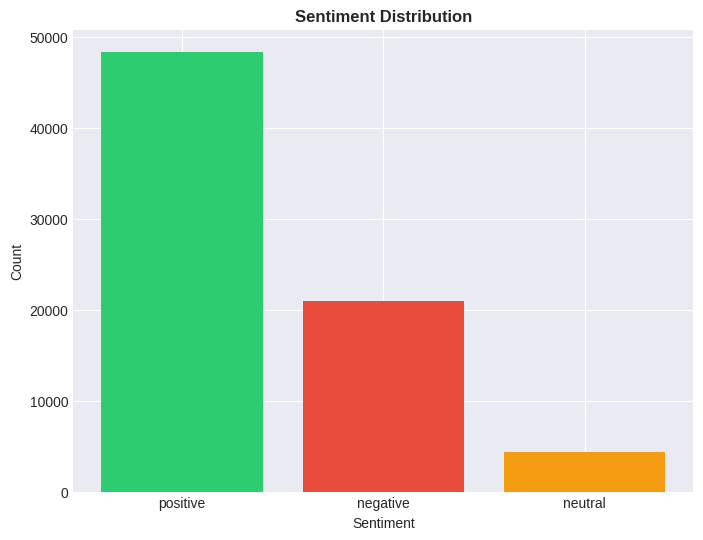

In [ ]:
# Distribusi Sentimen

sentiment_counts = df_clean['sentiment'].value_counts()

plt.bar(sentiment_counts.index, sentiment_counts.values,
        color=['#2ecc71', '#e74c3c', '#f39c12'])
plt.title('Sentiment Distribution', fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

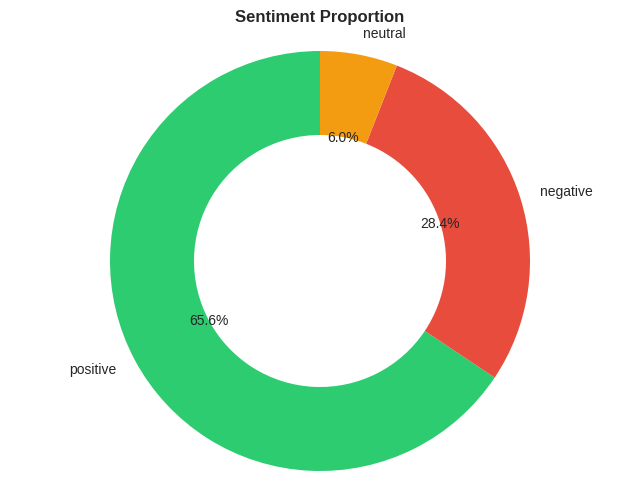

In [ ]:
# Donut Chart (Proporsi Sentimen)
fig, ax = plt.subplots()

ax.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#2ecc71', '#e74c3c', '#f39c12'],
    wedgeprops={'width': 0.4}
)

ax.axis('equal')
ax.set_title('Sentiment Proportion', fontweight='bold')
plt.show()


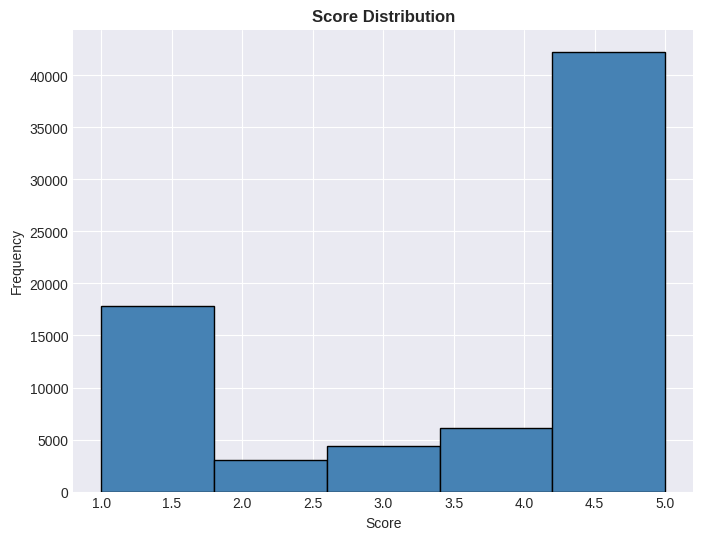

In [107]:
# Distribusi Skor
df_clean['score'].hist(bins=5, color='steelblue', edgecolor='black')
plt.title('Score Distribution', fontweight='bold')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


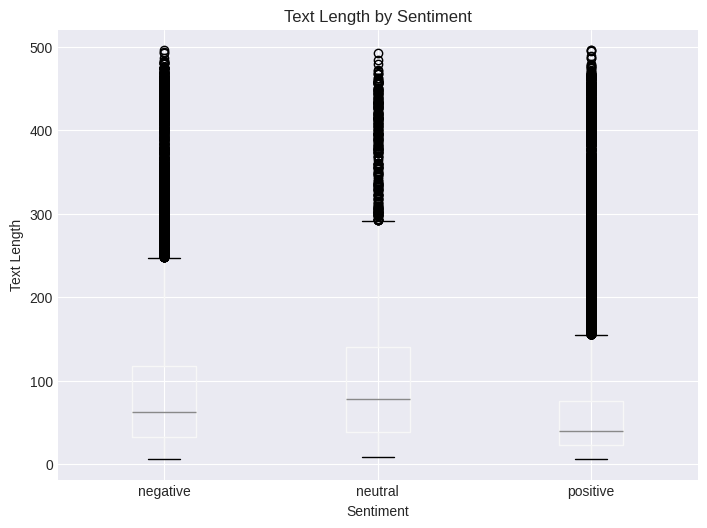

In [127]:
# Panjang Teks per Sentimen
df_clean['text_length'] = df_clean['content_cleaned'].str.len()
df_clean.boxplot(column='text_length', by='sentiment')
plt.title('Text Length by Sentiment')
plt.suptitle('')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()


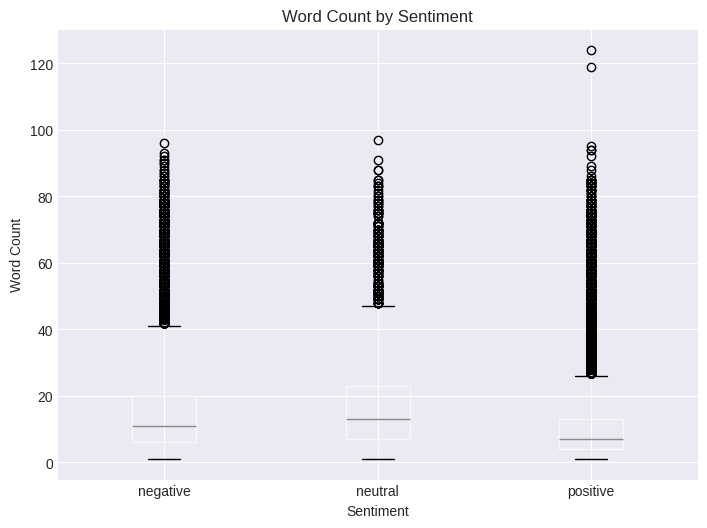

In [109]:
# Jumlah Kata per Sentimen

df_clean['word_count'] = df_clean['content_cleaned'].str.split().str.len()
df_clean.boxplot(column='word_count', by='sentiment')
plt.title('Word Count by Sentiment')
plt.suptitle('')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.show()


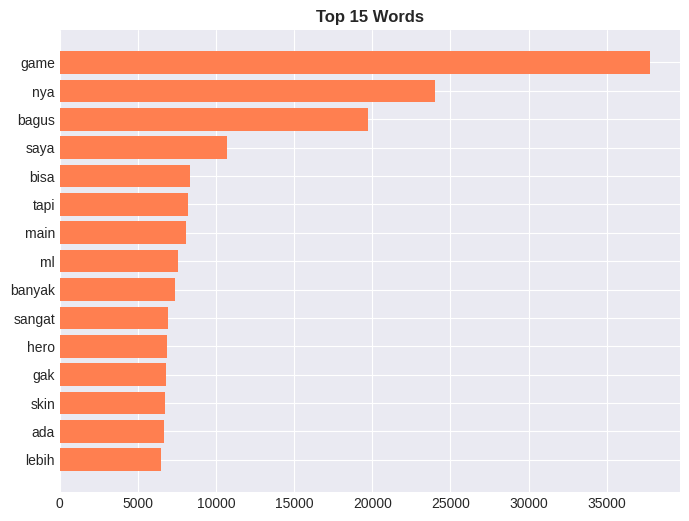

In [110]:
# 15 Kata Teratas
all_words = ' '.join(df_clean['content_cleaned']).split()
word_freq = Counter(all_words).most_common(15)

words, counts = zip(*word_freq)

plt.barh(range(len(words)), counts, color='coral')
plt.yticks(range(len(words)), words)
plt.title('Top 15 Words', fontweight='bold')
plt.gca().invert_yaxis()
plt.show()


In [111]:
plt.savefig('eda_plots.png', dpi=300, bbox_inches='tight')


<Figure size 800x600 with 0 Axes>

# **6: WordCloud Visualization**


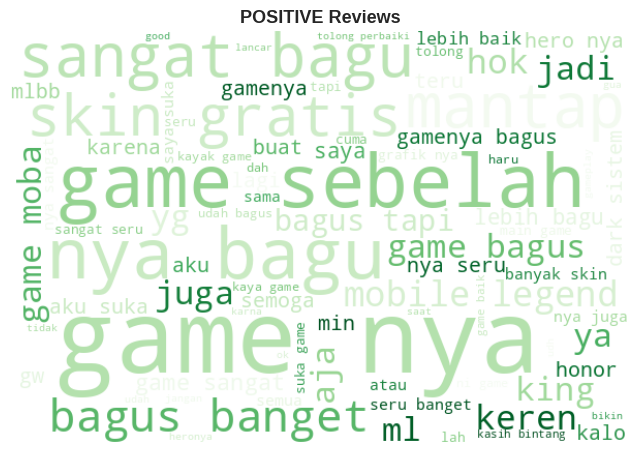

In [112]:
# WorldCloud Positive Reviews

text_pos = ' '.join(df_clean[df_clean['sentiment'] == 'positive']['content_cleaned'])

wc_pos = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='Greens',
    max_words=80
).generate(text_pos)

plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('POSITIVE Reviews', fontsize=13, fontweight='bold')
plt.show()


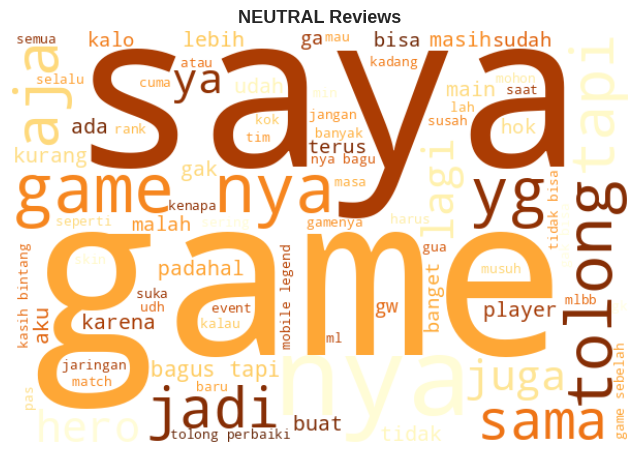

In [128]:
# WorldCloud Neutral Reviews
text_neu = ' '.join(df_clean[df_clean['sentiment'] == 'neutral']['content_cleaned'])

wc_neu = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='YlOrBr',
    max_words=80
).generate(text_neu)

plt.imshow(wc_neu, interpolation='bilinear')
plt.axis('off')
plt.title('NEUTRAL Reviews', fontsize=13, fontweight='bold')
plt.show()


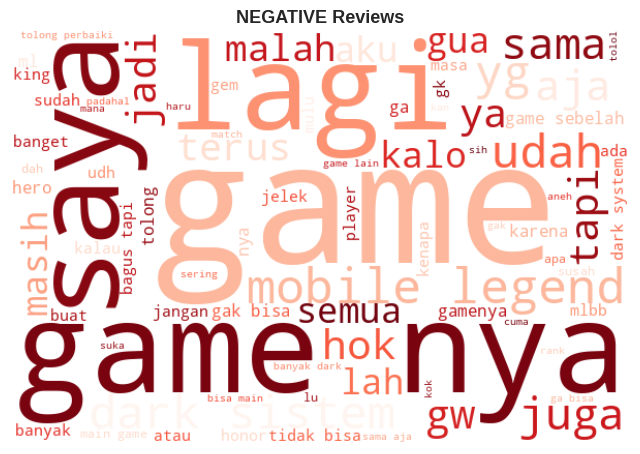

In [114]:
# WorldCloud Negative Reviews

text_neg = ' '.join(df_clean[df_clean['sentiment'] == 'negative']['content_cleaned'])

wc_neg = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='Reds',
    max_words=80
).generate(text_neg)

plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('NEGATIVE Reviews', fontsize=13, fontweight='bold')
plt.show()


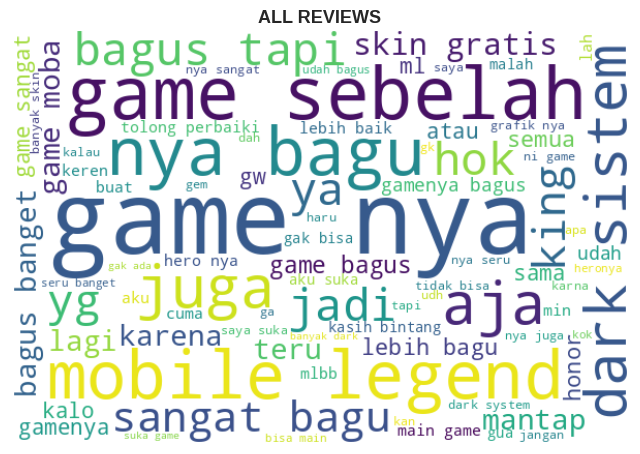

In [115]:
# WorldCloud All Reviews

all_text = ' '.join(df_clean['content_cleaned'])

wc_all = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='viridis',
    max_words=80
).generate(all_text)

plt.imshow(wc_all, interpolation='bilinear')
plt.axis('off')
plt.title('ALL REVIEWS', fontsize=13, fontweight='bold')
plt.show()


# **7: Prepare Data for Training**

In [ ]:
print("Tokenizing data...")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize with max length 128
max_len = 128
encoded = tokenizer(
    df_clean['content_cleaned'].tolist(),
    padding=True,
    truncation=True,
    max_length=max_len,
    return_tensors="pt"
)

# convert labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
labels = torch.tensor([label_map[label] for label in df_clean['sentiment']])

input_ids = encoded['input_ids']
attention_masks = encoded['attention_mask']

# split data
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, test_masks, _, _ = train_test_split(
    attention_masks, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nTrain size: {len(train_inputs)}")
print(f"Test size: {len(test_inputs)}")

# create dataloaders
batch_size = 16  # GPU can handle larger batches

train_data = TensorDataset(train_inputs, train_masks, train_labels)
test_data = TensorDataset(test_inputs, test_masks, test_labels)

train_loader = DataLoader(train_data, sampler=RandomSampler(train_data),
                          batch_size=batch_size)
test_loader = DataLoader(test_data, sampler=SequentialSampler(test_data),
                         batch_size=batch_size)

print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Tokenizing data...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Train size: 58992
Test size: 14749
Batch size: 16
Train batches: 3687
Test batches: 922


# **8: Model Setup**

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)
model.to(device)

# optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps=0,
                                           num_training_steps=total_steps)

print(f"\nTraining config:")
print(f"  Epochs: {epochs}")
print(f"  Total steps: {total_steps}")
print(f"  Learning rate: 2e-5")


Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training config:
  Epochs: 3
  Total steps: 11061
  Learning rate: 2e-5


# **9: Training Loop**

In [ ]:
def compute_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

training_history = []
best_acc = 0

print("Starting training...")

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    print('-' * 60)

    # training
    model.train()
    total_loss = 0
    train_acc = 0

    train_iterator = tqdm(train_loader, desc="Training")
    for batch in train_iterator:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        train_acc += compute_accuracy(logits.detach().cpu().numpy(),
                                      b_labels.cpu().numpy())

        train_iterator.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # validation
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            outputs = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)

            logits = outputs.logits
            loss = F.cross_entropy(logits, b_labels)

            val_loss += loss.item()
            val_acc += compute_accuracy(logits.cpu().numpy(), b_labels.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = val_acc / len(test_loader)

    print(f'\nTrain Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}')

    training_history.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'train_acc': avg_train_acc,
        'val_loss': avg_val_loss,
        'val_acc': avg_val_acc
    })

    if avg_val_acc > best_acc:
        best_acc = avg_val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f'Model saved with val_acc: {best_acc:.4f}')

    gc.collect()
    torch.cuda.empty_cache()

print(f'\nTraining complete! Best val accuracy: {best_acc:.4f}')


Starting training...

Epoch 1/3
------------------------------------------------------------


Validation: 100%|██████████| 922/922 [01:45<00:00,  8.73it/s]



Train Loss: 0.5116 | Train Acc: 0.8077
Val Loss: 0.4582 | Val Acc: 0.8395
Model saved with val_acc: 0.8395

Epoch 2/3
------------------------------------------------------------


Validation: 100%|██████████| 922/922 [01:45<00:00,  8.73it/s]



Train Loss: 0.4090 | Train Acc: 0.8526
Val Loss: 0.4439 | Val Acc: 0.8411
Model saved with val_acc: 0.8411

Epoch 3/3
------------------------------------------------------------


Validation: 100%|██████████| 922/922 [01:45<00:00,  8.72it/s]



Train Loss: 0.3486 | Train Acc: 0.8770
Val Loss: 0.4666 | Val Acc: 0.8415
Model saved with val_acc: 0.8415

Training complete! Best val accuracy: 0.8415


# **10: Training History Visualization**

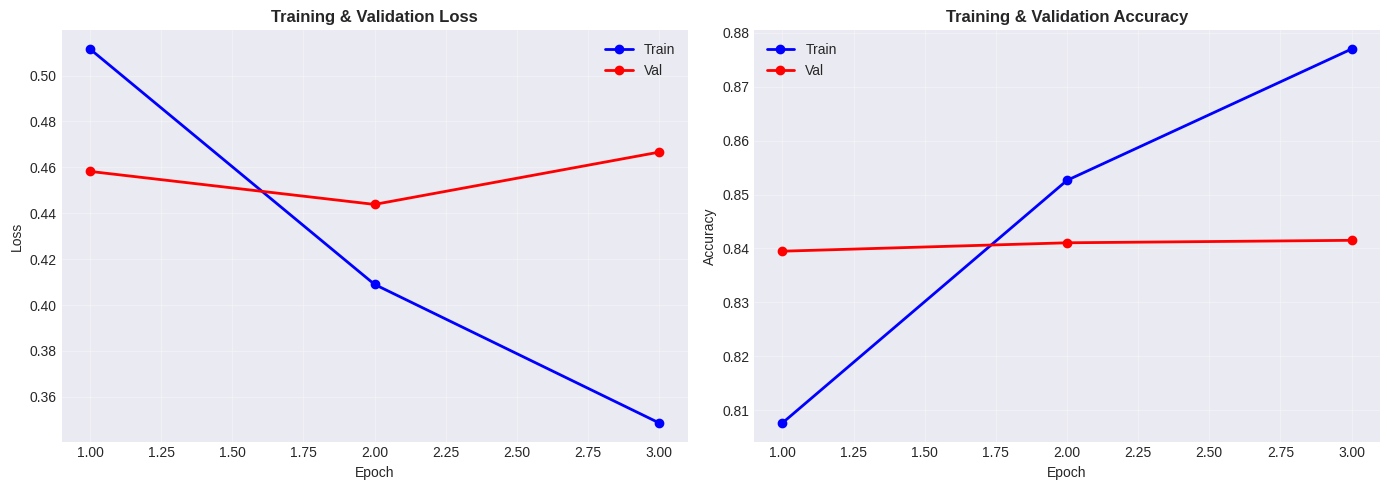

   epoch  train_loss  train_acc  val_loss   val_acc
0      1    0.511574   0.807652  0.458241  0.839500
1      2    0.409013   0.852641  0.443857  0.841059
2      3    0.348645   0.877000  0.466634  0.841518


In [ ]:
history_df = pd.DataFrame(training_history)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# loss plot
ax1.plot(history_df['epoch'], history_df['train_loss'], 'b-o', label='Train', linewidth=2)
ax1.plot(history_df['epoch'], history_df['val_loss'], 'r-o', label='Val', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# accuracy plot
ax2.plot(history_df['epoch'], history_df['train_acc'], 'b-o', label='Train', linewidth=2)
ax2.plot(history_df['epoch'], history_df['val_acc'], 'r-o', label='Val', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training & Validation Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(history_df)

# **11: Model Evaluation**

In [ ]:

model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()

predictions = []
true_labels = []
probs_list = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)

        logits = outputs.logits
        probs = F.softmax(logits, dim=1)

        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())
        probs_list.extend(probs.cpu().numpy())

# metrics
print("\nClassification Report:")
print(classification_report(true_labels, predictions,
                          target_names=['negative', 'neutral', 'positive'],
                          digits=4))

acc = accuracy_score(true_labels, predictions)
f1_macro = f1_score(true_labels, predictions, average='macro')
f1_weighted = f1_score(true_labels, predictions, average='weighted')

print(f"\nOverall Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 (macro): {f1_macro:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}")



Evaluating: 100%|██████████| 922/922 [01:38<00:00,  9.38it/s]



Classification Report:
              precision    recall  f1-score   support

    negative     0.7631    0.8205    0.7908      4189
     neutral     0.2662    0.0466    0.0794       879
    positive     0.8853    0.9228    0.9037      9681

    accuracy                         0.8415     14749
   macro avg     0.6382    0.5967    0.5913     14749
weighted avg     0.8137    0.8415    0.8225     14749


Overall Metrics:
Accuracy: 0.8415
F1 (macro): 0.5913
F1 (weighted): 0.8225


# **12: Confusion Matrix**

In [116]:
# Hitung Confusion Matrix

cm = confusion_matrix(true_labels, predictions)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


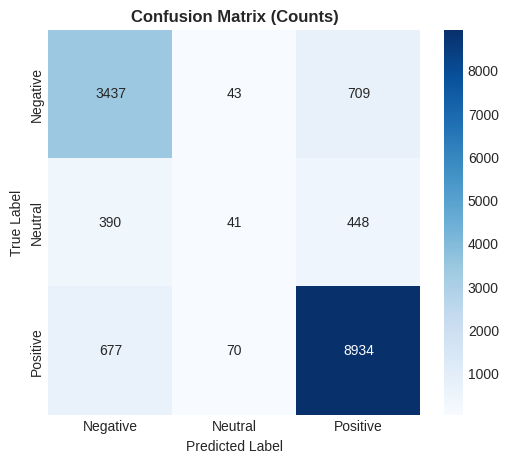

In [117]:
# Confusion Matrix (Count)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)
plt.title('Confusion Matrix (Counts)', fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


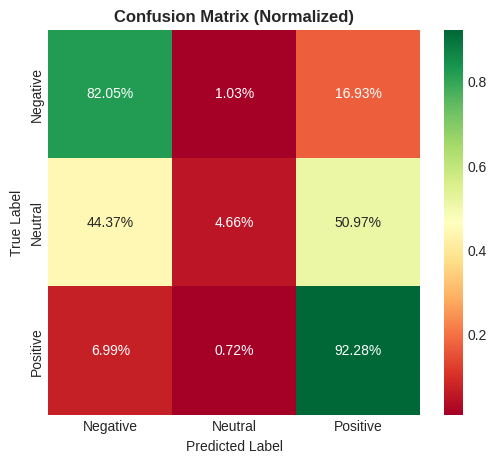

In [118]:
# Confusion Matrix (Normalized)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm, annot=True, fmt='.2%', cmap='RdYlGn',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)
plt.title('Confusion Matrix (Normalized)', fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# **13: Error Analysis**

In [120]:
# Buat dataframe hasil prediksi
label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}

results_df = pd.DataFrame({
    'true': [label_names[l] for l in true_labels],
    'pred': [label_names[p] for p in predictions],
    'confidence': [max(prob) for prob in probs_list]
})

# Tandai prediksi benar atau salah
results_df['correct'] = results_df['true'] == results_df['pred']

# Ambil data yang salah
errors = results_df[~results_df['correct']]

In [121]:
# Ringkasan Error Analysis

total = len(results_df)
n_errors = len(errors)
error_pct = n_errors / total * 100

print(f"\nError Analysis Summary:")
print(f"Total errors: {n_errors} out of {total} ({error_pct:.2f}%)\n")

print("Errors by True Label:")
print(errors['true'].value_counts(), "\n")

print("Errors by Predicted Label:")
print(errors['pred'].value_counts())



Error Analysis Summary:
Total errors: 2337 out of 14749 (15.85%)

Errors by True Label:
true
neutral     838
negative    752
positive    747
Name: count, dtype: int64 

Errors by Predicted Label:
pred
positive    1157
negative    1067
neutral      113
Name: count, dtype: int64


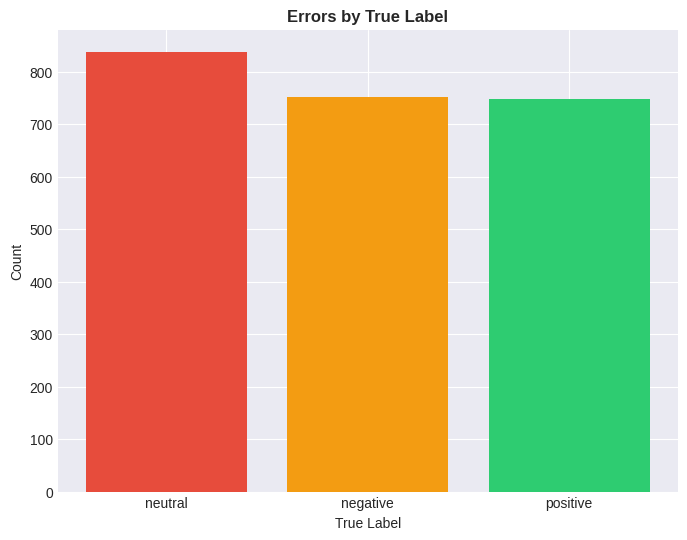

In [122]:
# Distribusi Error Berdasarkan True Label

err_true = errors['true'].value_counts()
plt.bar(err_true.index, err_true.values, color=['#e74c3c', '#f39c12', '#2ecc71'])
plt.title('Errors by True Label', fontweight='bold')
plt.xlabel('True Label')
plt.ylabel('Count')
plt.show()


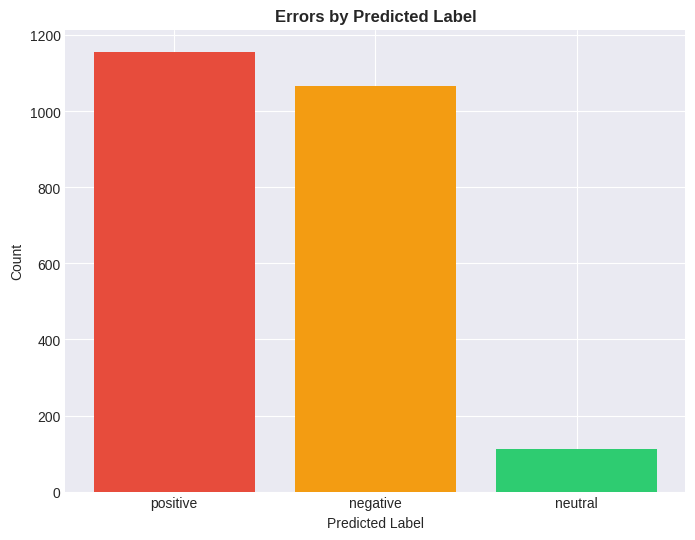

In [123]:
# Distribusi Error Berdasarkan Prediksi

err_pred = errors['pred'].value_counts()
plt.bar(err_pred.index, err_pred.values, color=['#e74c3c', '#f39c12', '#2ecc71'])
plt.title('Errors by Predicted Label', fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.show()


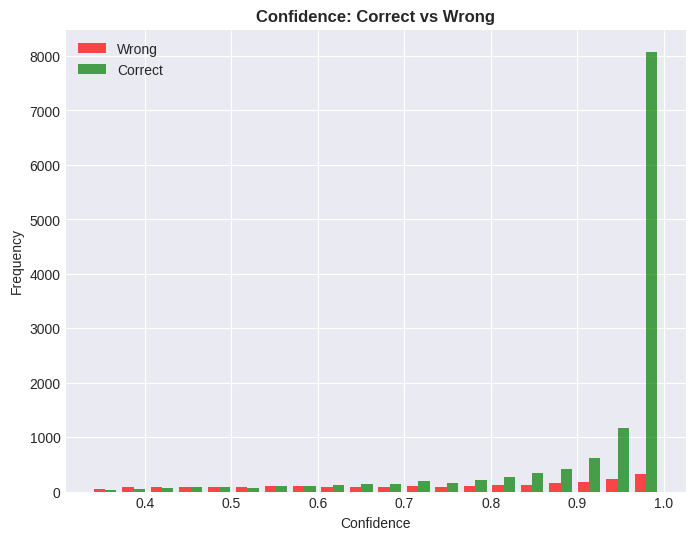

In [124]:
# Confidence: Benar vs Salah

plt.hist(
    [errors['confidence'], results_df[results_df['correct']]['confidence']],
    bins=20, label=['Wrong', 'Correct'],
    color=['red', 'green'], alpha=0.7
)
plt.title('Confidence: Correct vs Wrong', fontweight='bold')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.legend()
plt.show()


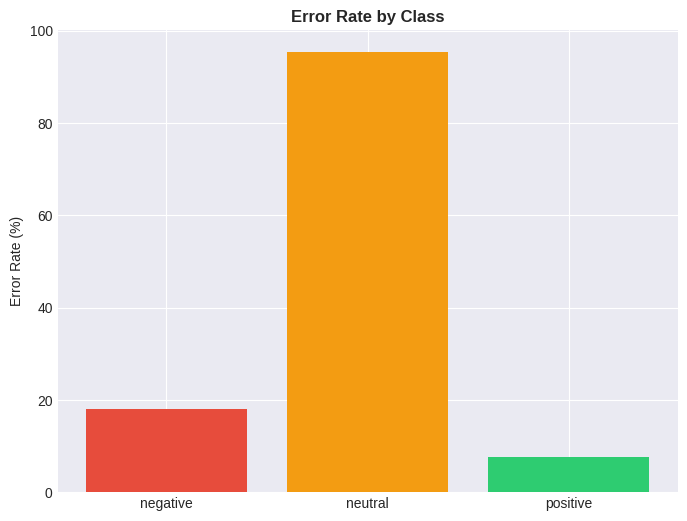

In [125]:
# Error Rate per Class

error_rates = []
for sent in ['negative', 'neutral', 'positive']:
    total_class = len(results_df[results_df['true'] == sent])
    err_class = len(errors[errors['true'] == sent])
    rate = (err_class / total_class * 100) if total_class > 0 else 0
    error_rates.append(rate)

plt.bar(['negative', 'neutral', 'positive'], error_rates,
        color=['#e74c3c', '#f39c12', '#2ecc71'])
plt.title('Error Rate by Class', fontweight='bold')
plt.ylabel('Error Rate (%)')
plt.show()


# **14: Prediction Function for New Text**

In [126]:
def predict_sentiment(text, model, tokenizer, device):
    """Predict sentiment for new text"""

    # preprocess
    cleaned = clean_text(text)

    # tokenize
    encoded = tokenizer.encode_plus(
        cleaned,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    # predict
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)

    confidence, pred_class = torch.max(probs, dim=1)
    sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}

    return {
        'text': text,
        'sentiment': sentiment_map[pred_class.item()],
        'confidence': confidence.item(),
        'probs': {
            'negative': probs[0][0].item(),
            'neutral': probs[0][1].item(),
            'positive': probs[0][2].item()
        }
    }

# test examples
test_samples = [
    "Game ini sangat bagus dan menyenangkan!",
    "Terrible game, banyak bug dan lag",
    "Biasa saja, tidak terlalu bagus tidak terlalu buruk",
    "Grafisnya luar biasa, gameplay smooth banget!",
    "Waste of time, sangat mengecewakan"
]

print("\nTesting prediction function:\n")
for sample in test_samples:
    result = predict_sentiment(sample, model, tokenizer, device)
    print(f"Text: {result['text']}")
    print(f"Sentiment: {result['sentiment'].upper()} (conf: {result['confidence']:.3f})")
    print(f"Probs: neg={result['probs']['negative']:.3f}, "
          f"neu={result['probs']['neutral']:.3f}, pos={result['probs']['positive']:.3f}")
    print("-" * 60)



Testing prediction function:

Text: Game ini sangat bagus dan menyenangkan!
Sentiment: POSITIVE (conf: 0.994)
Probs: neg=0.002, neu=0.004, pos=0.994
------------------------------------------------------------
Text: Terrible game, banyak bug dan lag
Sentiment: NEGATIVE (conf: 0.974)
Probs: neg=0.974, neu=0.011, pos=0.015
------------------------------------------------------------
Text: Biasa saja, tidak terlalu bagus tidak terlalu buruk
Sentiment: NEGATIVE (conf: 0.719)
Probs: neg=0.719, neu=0.162, pos=0.119
------------------------------------------------------------
Text: Grafisnya luar biasa, gameplay smooth banget!
Sentiment: POSITIVE (conf: 0.995)
Probs: neg=0.002, neu=0.003, pos=0.995
------------------------------------------------------------
Text: Waste of time, sangat mengecewakan
Sentiment: NEGATIVE (conf: 0.975)
Probs: neg=0.975, neu=0.010, pos=0.015
------------------------------------------------------------


# **15: Save Model to Google Drive**

In [ ]:

# save to drive so you don't lose it
model.save_pretrained('/content/drive/MyDrive/bert_sentiment_model')
tokenizer.save_pretrained('/content/drive/MyDrive/bert_sentiment_model')

print("Model saved to Google Drive!")
print("Location: /content/drive/MyDrive/bert_sentiment_model")

# to load later:
# model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_sentiment_model')
# tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_sentiment_model')


Model saved to Google Drive!
Location: /content/drive/MyDrive/bert_sentiment_model


# **16: Final Summary**

In [ ]:

print("\n" + "="*70)
print(" "*25 + "SUMMARY")
print("="*70)
print(f"\nDataset: {len(df_clean)} reviews")
print(f"Train/Test split: {len(train_inputs)}/{len(test_inputs)}")
print(f"\nFinal Results:")
print(f"  Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print(f"  F1-Score (macro): {f1_macro:.4f}")
print(f"  F1-Score (weighted): {f1_weighted:.4f}")
print(f"\nModel saved to Google Drive")
print(f"All visualizations saved as PNG files")
print("\n" + "="*70)

# download all plots to local
from google.colab import files

plot_files = ['eda_plots.png', 'wordclouds.png', 'training_history.png',
              'confusion_matrix.png', 'error_analysis.png']

print("\nDownloading plots...")
for f in plot_files:
    try:
        files.download(f)
    except:
        print(f"Could not download {f}")

print("\nDone! Check your downloads folder.")


                         SUMMARY

Dataset: 73741 reviews
Train/Test split: 58992/14749

Final Results:
  Accuracy: 0.8415 (84.15%)
  F1-Score (macro): 0.5913
  F1-Score (weighted): 0.8225

Model saved to Google Drive
All visualizations saved as PNG files




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Done! Check your downloads folder.
